In [1]:
!pip install torchinfo

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

import numpy as np
import cv2

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

import platform
import psutil

import random
import glob
from tqdm import tqdm
from tqdm.notebook import tqdm

import PIL
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from PIL import ImageEnhance, ImageOps, ImageFilter
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw

from tabulate import tabulate

### Configuration

In [4]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 12.67
GPU: Tesla T4


### Seed Value

In [5]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Dataset

In [6]:
root_dir = "/content/drive/MyDrive/resizemango"

file_paths = []
labels = []

for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)
    if os.path.isdir(class_dir):
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

df = pd.DataFrame({'file_path': file_paths, 'label': labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: Anthracnose, Count: 500
Class: Die Back, Count: 500
Class: Powdery Mildew, Count: 500
Class: Cutting Weevil, Count: 500
Class: Healthy, Count: 500
Class: Bacterial Canker, Count: 500
Class: Gall Midge, Count: 500
Class: Sooty Mould, Count: 500


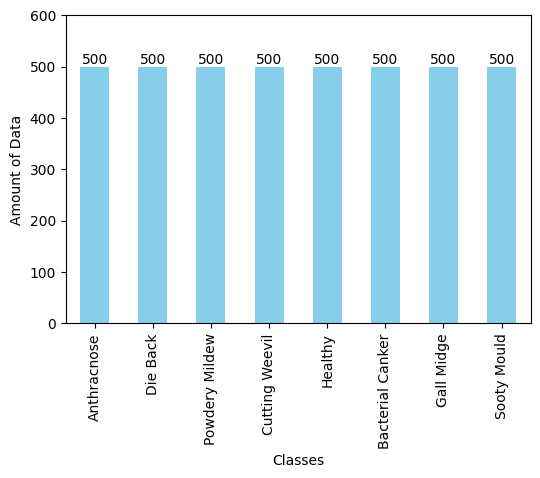

In [7]:
class_counts_df = df['label'].value_counts()

for class_name, count in class_counts_df.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(6, 4))
ax = class_counts_df.plot(kind='bar', color='skyblue')

plt.xlabel('Classes')
plt.ylabel('Amount of Data')
plt.xticks(rotation=90)

for i, count in enumerate(class_counts_df):
    ax.text(i, count + 5, str(count), ha='center')

plt.ylim(0, max(class_counts_df) * 1.2)
plt.show()

### Sample Image

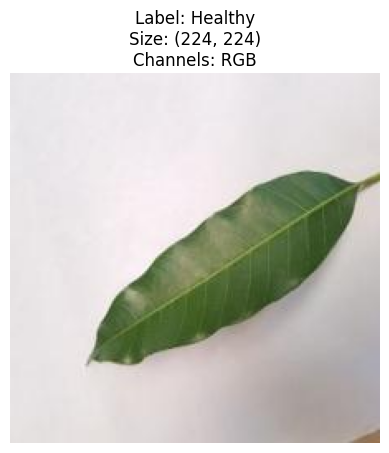

In [8]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)

size = image.size
channels = 'Grayscale' if image.mode == 'L' else 'RGB'
plt.title(f"Label: {label}\nSize: {size}\nChannels: {channels}")
plt.imshow(image)
plt.axis('off')
plt.show()

### Dataset Splits

In [ ]:
train_dataframe, test_dataframe = train_test_split(df, test_size=0.2, random_state=42)
test_dataframe, valid_dataframe = train_test_split(test_dataframe, test_size=0.5, random_state=42)
ulb_dataframe, lb_dataframe = train_test_split(train_dataframe, test_size=0.30, random_state=42)

In [10]:
print("Unlabeled Data: ", len(ulb_dataframe))
print("Labeled Data: ", len(lb_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_dataframe))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Unlabeled Data:  2080
Labeled Data:  1120
Validation Data:  400
Test Data:  400
-------------------------------------------
Total amounts of data in the dataset:  4000


In [11]:
class_counts_lb = lb_dataframe['label'].value_counts()
class_counts_ulb = ulb_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_dataframe['label'].value_counts()

lb_table_data = [[class_name, count] for class_name, count in class_counts_lb.items()]
ulb_table_data = [[class_name, count] for class_name, count in class_counts_ulb.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Labeled Dataset")
print(tabulate(lb_table_data, headers=["Class", "Count"]))
print("\nUnlabeled Dataset")
print(tabulate(ulb_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Labeled Dataset
Class               Count
----------------  -------
Powdery Mildew        152
Gall Midge            151
Bacterial Canker      144
Healthy               144
Anthracnose           136
Cutting Weevil        135
Die Back              133
Sooty Mould           125

Unlabeled Dataset
Class               Count
----------------  -------
Sooty Mould           273
Die Back              268
Healthy               265
Anthracnose           260
Cutting Weevil        257
Powdery Mildew        255
Bacterial Canker      251
Gall Midge            251

Validation Dataset
Class               Count
----------------  -------
Cutting Weevil         61
Sooty Mould            57
Die Back               54
Bacterial Canker       50
Powdery Mildew         46
Gall Midge             46
Anthracnose            45
Healthy                41

Test Dataset
Class               Count
----------------  -------
Anthracnose            59
Bacterial Canker       55
Gall Midge             52
Healthy              

### Device

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Variables

In [13]:
total_class = 8
threshold_value = 0.80

### Batch Sizes

In [14]:
mu = 4
lb_batch = 8
ulb_batch = mu*lb_batch
val_batch = 8
print("Batch Size of Labeled Data: ", lb_batch)
print("Batch Size of Unlabeled Data: ", lb_batch,"x",mu, " = ", ulb_batch)
print("Batch Size of Validation Data: ", val_batch)

Batch Size of Labeled Data:  8
Batch Size of Unlabeled Data:  8 x 4  =  32
Batch Size of Validation Data:  8


### Checkpoint

In [15]:
save_path_checkpoints = "/content/drive/MyDrive/mangofm"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Dataset Class, Dataloader and Augmentations

In [16]:
class ImageDatasetWithAugmentation(Dataset):
    def __init__(self, dataframe, weak_transform, strong_transform, normalize, is_lb=False):
        self.dataframe = dataframe
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = {'Anthracnose': 0,'Bacterial Canker': 1,'Cutting Weevil': 2,'Die Back': 3,'Gall Midge': 4, 'Healthy': 5, 'Powdery Mildew': 6, 'Sooty Mould': 7}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(self.weak_transform(image)), label
        else:
            weak_image = self.weak_transform(image)
            strong_image = self.strong_transform(image)
            return self.normalize(weak_image), self.normalize(strong_image)

In [17]:
class ImageDatasetNoAugmentation(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map =  {'Anthracnose': 0,'Bacterial Canker': 1,'Cutting Weevil': 2,'Die Back': 3,'Gall Midge': 4, 'Healthy': 5, 'Powdery Mildew': 6, 'Sooty Mould': 7}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [18]:
def train_data_transfrom():

    def ShearX(img, v):  # [-0.3, 0.3]
        assert -0.3 <= v <= 0.3
        if random.random() > 0.5:
            v = -v
        return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


    def ShearY(img, v):  # [-0.3, 0.3]
        assert -0.3 <= v <= 0.3
        if random.random() > 0.5:
            v = -v
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


    def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
        assert -0.45 <= v <= 0.45
        if random.random() > 0.5:
            v = -v
        v = v * img.size[0]
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


    def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
        assert -0.45 <= v <= 0.45
        if random.random() > 0.5:
            v = -v
        v = v * img.size[1]
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


    def Rotate(img, v):  # [-30, 30]
        assert -30 <= v <= 30
        if random.random() > 0.5:
            v = -v
        return img.rotate(v)


    def AutoContrast(img, _):
        return PIL.ImageOps.autocontrast(img)


    def Invert(img, _):
        return PIL.ImageOps.invert(img)


    def Equalize(img, _):
        return PIL.ImageOps.equalize(img)


    def Solarize(img, v):  # [0, 256]
        assert 0 <= v <= 256
        inverted_v = 256 - v
        return PIL.ImageOps.solarize(img, inverted_v)


    def Posterize(img, v):  # [4, 8]
        v = int(v)
        v = max(1, v)
        return PIL.ImageOps.posterize(img, v)


    def Contrast(img, v):  # [0.1,1.9]
        assert 0.1 <= v <= 1.9
        enhanced_v = 1.9 - v + 0.1
        return PIL.ImageEnhance.Contrast(img).enhance(enhanced_v)


    def Color(img, v):
        assert 0.1 <= v <= 1.9
        v = 1.9 - v
        return PIL.ImageEnhance.Color(img).enhance(v)


    def Brightness(img, v):  # [0.1,1.9]
        assert 0.1 <= v <= 1.9
        v = 1.9 - v
        return PIL.ImageEnhance.Brightness(img).enhance(v)


    def Sharpness(img, v):  # [0.1,1.9]
        assert 0.1 <= v <= 1.9
        return PIL.ImageEnhance.Sharpness(img).enhance(v)


    def CutoutAbs(img, v):  # [0, 60] => percentage: [0, 0.2]
        # assert 0 <= v <= 20
        if v < 0:
            return img
        w, h = img.size
        x0 = np.random.uniform(w)
        y0 = np.random.uniform(h)

        x0 = int(max(0, x0 - v / 2.))
        y0 = int(max(0, y0 - v / 2.))
        x1 = min(w, x0 + v)
        y1 = min(h, y0 + v)

        xy = (x0, y0, x1, y1)
        color = (125, 123, 114)
        # color = (0, 0, 0)
        img = img.copy()
        PIL.ImageDraw.Draw(img).rectangle(xy, color)
        return img


    def Cutout(img, v):  # [0, 60] => percentage: [0, 0.2]
        assert 0.0 <= v <= 0.3
        if v <= 0.:
            return img

        v = v * img.size[0]
        return CutoutAbs(img, v)


    def Identity(img, v):
        return img


    def augment_list():
        aug_list = [
            (AutoContrast, 0, 1),
            (Equalize, 0, 1),
            (Invert, 0, 1),
            (Rotate, 0, 30),
            (Posterize, 0, 4),
            (Solarize, 0, 256),
            (Color, 0.1, 1.9),
            (Contrast, 0.1, 1.9),
            (Brightness, 0.1, 1.9),
            (Sharpness, 0.1, 1.9),
            (ShearX, 0.0, 0.3),
            (ShearY, 0.0, 0.3),
            (Cutout, 0, 0.3),
            (TranslateX, 0.0, 0.33),
            (TranslateY, 0.0, 0.33),
            (Identity, 0, 1)
        ]

        return aug_list


    class RandAugment:
        def __init__(self, n, m):
            self.n = n
            self.m = m      # [0, 30]
            self.augment_list = augment_list()

        def __call__(self, img):
            ops = random.choices(self.augment_list, k=self.n)
            for op, minval, maxval in ops:
                val = (float(self.m) / 30) * float(maxval - minval) + minval
                img = op(img, val)

            return img


    strong_transform = transforms.Compose([
        RandAugment(n=4, m=10)
    ])

    weak_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(degrees=0, translate=(0.125, 0.125)),
    ])

    normalize = transforms.Compose([
            transforms.ToTensor()])

    ulb_dataset = ImageDatasetWithAugmentation (
        ulb_dataframe,
        weak_transform,
        strong_transform,
        normalize,
        is_lb=False
    )

    lb_dataset = ImageDatasetWithAugmentation(
        lb_dataframe,
        weak_transform,
        strong_transform,
        normalize,
        is_lb=True
    )

    dataloader_ulb_dataset = DataLoader(ulb_dataset, batch_size = ulb_batch, shuffle=True, num_workers=2)
    dataloader_lb_dataset = DataLoader(lb_dataset, batch_size = lb_batch, shuffle=True, num_workers=2)

    return dataloader_ulb_dataset, dataloader_lb_dataset

dataloader_ulb_dataset, dataloader_lb_dataset = train_data_transfrom()

In [19]:
def valid_data_transfrom():

    normalize = transforms.Compose([
            transforms.ToTensor()])

    valid_dataset = ImageDatasetNoAugmentation(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDatasetNoAugmentation(
        test_dataframe,
        normalize,
        is_lb=True
    )

    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_valid_dataset, dataloader_test_dataset

dataloader_valid_dataset, dataloader_test_dataset = valid_data_transfrom()

### Neural Network

In [20]:
learning_rate = 0.0009

model = models.densenet201(weights=models.DenseNet201_Weights.DEFAULT)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, total_class)
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)
summary(model, input_size=(lb_batch, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 89.0MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [8, 8]                    --
├─Sequential: 1-1                        [8, 1920, 7, 7]           --
│    └─Conv2d: 2-1                       [8, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [8, 64, 112, 112]         128
│    └─ReLU: 2-3                         [8, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [8, 64, 56, 56]           --
│    └─_DenseBlock: 2-5                  [8, 256, 56, 56]          --
│    │    └─_DenseLayer: 3-1             [8, 32, 56, 56]           45,440
│    │    └─_DenseLayer: 3-2             [8, 32, 56, 56]           49,600
│    │    └─_DenseLayer: 3-3             [8, 32, 56, 56]           53,760
│    │    └─_DenseLayer: 3-4             [8, 32, 56, 56]           57,920
│    │    └─_DenseLayer: 3-5             [8, 32, 56, 56]           62,080
│    │    └─_DenseLayer: 3-6             [8, 32, 56, 56]     

# FixMatch Training

##### FixMatch Implementation

In [ ]:
def train_fixMatch(model, optimizer, dataloader_lb_dataset, dataloader_ulb_dataset, device, threshold):
    model.train()

    losses = []
    correct_predictions = 0
    total_samples = 0

    pbar = tqdm(dataloader_lb_dataset)

    ulb_iter = iter(dataloader_ulb_dataset)

    for batch_lb in pbar:
        model.zero_grad()

        # labelled data
        x_lb, y = batch_lb
        x_lb, y = x_lb.to(device), y.to(device)

        # unlabelled data
        try:
            x_weak, x_strong = next(ulb_iter)
        except StopIteration:
            ulb_iter = iter(dataloader_ulb_dataset)
            x_weak, x_strong = next(ulb_iter)

        x_weak, x_strong = x_weak.to(device), x_strong.to(device)

        # concat all x
        all_x = torch.cat([x_lb, x_weak, x_strong], dim=0)

        # compute logits
        all_logits = model(all_x)

        # logits and loss for labelled data
        logits_lb = all_logits[:x_lb.size(0)]
        loss_lb = F.cross_entropy(logits_lb, y)

        # logits for unlabelled data
        logits_ulb = all_logits[x_lb.size(0):]
        logits_weak, logits_strong = torch.chunk(logits_ulb, 2, dim=0)

        # gradient stopping for weak augmented
        logits_weak = logits_weak.detach()

        # class probabilities
        probs_weak = F.softmax(logits_weak, dim=1)

        # pseudo labels (torch.max outputs the maximum values and the argmax)
        max_prob, pseudo_label = torch.max(probs_weak, dim=1)

        # mask for confident predictions
        mask = (max_prob > threshold).float()

        # mask non-confident prediction
        pseudo_label = pseudo_label.masked_fill(mask == 0, 0)

        # unsupervised loss by ignoring non-confident prediction
        loss_ulb = F.cross_entropy(logits_strong, pseudo_label, ignore_index=-1)

        # total loss
        loss = loss_lb + loss_ulb

        _, predicted = torch.max(logits_lb, 1)
        correct_predictions += (predicted == y).sum().item()
        total_samples += y.size(0)

        loss.backward()
        optimizer.step()

        loss_item = loss.item()
        losses.append(loss_item)

        pbar.set_description(f'train loss = {np.array(losses).mean():.3f}, accuracy = {correct_predictions / total_samples:.3f}')


    return np.array(losses).mean(), correct_predictions / total_samples

##### Validation

In [22]:
def validate(model, dataloader, device):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    val_losses = []

    with torch.no_grad():
        for batch in dataloader:
            x_val, y_val = batch
            x_val, y_val = x_val.to(device), y_val.to(device)

            logits_val = model(x_val)
            loss_val = F.cross_entropy(logits_val, y_val)

            _, predicted_val = torch.max(logits_val, 1)
            correct_predictions += (predicted_val == y_val).sum().item()
            total_samples += y_val.size(0)

            val_losses.append(loss_val.item())

    accuracy = correct_predictions / total_samples
    val_loss = np.array(val_losses).mean()

    return accuracy, val_loss

##### Training

In [23]:
import time
start_time = time.time()

num_epochs = 25
early_stopping_rounds = 5
total_iterations = 0

num_epochs_without_improvement = 0
num_epochs_loss_greater = 0

losses = []
accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0
prev_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_fixMatch(model, optimizer, dataloader_lb_dataset, dataloader_ulb_dataset, device, threshold=threshold_value)
    val_accuracy, val_loss = validate(model, dataloader_valid_dataset, device)

    losses.append(train_loss)
    accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs} - '
          f'Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.3f} - '
          f'Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch + 1
        filepath = f"{save_path_checkpoints}/model.pt"
        checkpoint = {
            "epoch": epoch + 1,
            "model_weight": model.state_dict(),
            "optimizer_state": optimizer.state_dict()
        }
        torch.save(checkpoint, filepath)
        print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_accuracy:.3f}")
        num_epochs_without_improvement = 0
    else:
        num_epochs_without_improvement += 1

    if val_loss > train_loss:
        num_epochs_loss_greater += 1
    else:
        num_epochs_loss_greater = 0

    if num_epochs_without_improvement >= early_stopping_rounds or num_epochs_loss_greater >= early_stopping_rounds:
        print(f"Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stopping_rounds} consecutive epochs. Training stopped.")
        break

print("Training complete.........")

end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")
print("Training Time:", training_time/60, "minitues")

  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 1/25 - Train Loss: 1.146, Train Accuracy: 0.829 - Validation Loss: 0.025, Validation Accuracy: 0.998
Best model saved at epoch 1 with validation accuracy: 0.998


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 2/25 - Train Loss: 0.322, Train Accuracy: 0.997 - Validation Loss: 0.013, Validation Accuracy: 1.000
Best model saved at epoch 2 with validation accuracy: 1.000


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 3/25 - Train Loss: 0.238, Train Accuracy: 0.999 - Validation Loss: 0.010, Validation Accuracy: 1.000


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 4/25 - Train Loss: 0.200, Train Accuracy: 1.000 - Validation Loss: 0.006, Validation Accuracy: 1.000


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 5/25 - Train Loss: 0.151, Train Accuracy: 0.999 - Validation Loss: 0.003, Validation Accuracy: 1.000


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 6/25 - Train Loss: 0.142, Train Accuracy: 1.000 - Validation Loss: 0.006, Validation Accuracy: 1.000


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 7/25 - Train Loss: 0.130, Train Accuracy: 0.998 - Validation Loss: 0.003, Validation Accuracy: 1.000
Early stopping criteria met. No improvement in validation accuracy or validation loss for 5 consecutive epochs. Training stopped.
Training complete.........
Training Time: 1604.0259845256805 seconds
Training Time: 26.733766408761344 minitues


In [ ]:
data = {
    'Epoch': list(range(1, len(losses) + 1)),
    'Train Loss': losses,
    'Train Accuracy': accuracies,
    'Validation Loss': val_losses,
    'Validation Accuracy': val_accuracies
}

df = pd.DataFrame(data)

In [26]:
print(losses)
print()
print(accuracies)
print()
print(val_losses)
print()
print(val_accuracies)

[1.1459664180874825, 0.32196079721408233, 0.2382338191515633, 0.2004548477408077, 0.151477854033666, 0.14222456192531224, 0.1302185488133026]

[0.8285714285714286, 0.9973214285714286, 0.9991071428571429, 1.0, 0.9991071428571429, 1.0, 0.9982142857142857]

[0.025370033513754605, 0.013134452770464123, 0.010208421000279487, 0.005801807353273034, 0.0030501702008768916, 0.0062046970764640715, 0.0033190080831991507]

[0.9975, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


##### Plots

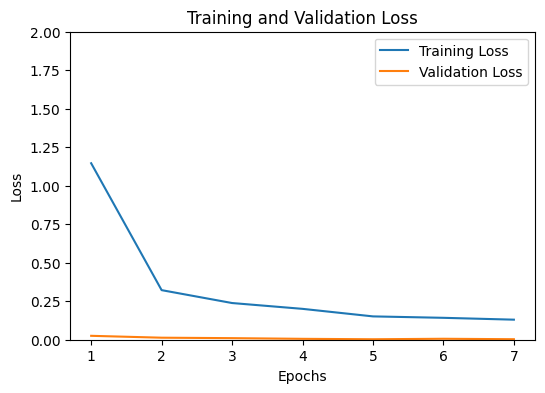

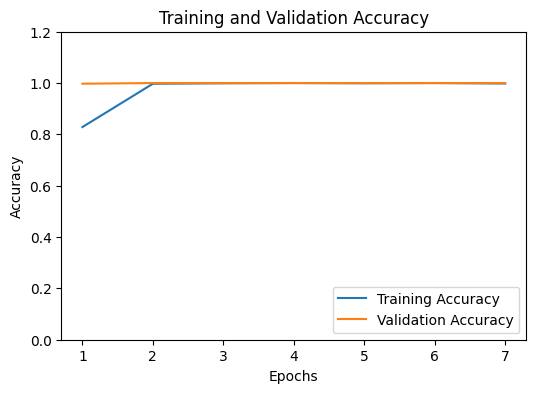

In [27]:
epochs = range(1, len(losses)+1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.2)
plt.show()

### FixMatch Model Evaluation

In [29]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_accuracy, best_val_loss = validate(model, dataloader_valid_dataset, device)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

test_accuracy, test_loss = validate(model, dataloader_test_dataset, device)
print(f"Test Accuracy: {test_accuracy:.3f}")

<ipython-input-29-3cc60da8e16d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_checkpoint_path)


Best model (from epoch 2) - Validation Loss: 0.013, Validation Accuracy: 1.000
Test Accuracy: 0.995


In [30]:
def get_predictions_labels(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            x, y = x.to(device), y.to(device)

            logits = model(x)
            predictions = torch.argmax(logits, dim=1).cpu().numpy()

            all_predictions.extend(predictions)
            all_labels.extend(y.cpu().numpy())

    return all_predictions, all_labels

test_predictions, test_labels = get_predictions_labels(model, dataloader_test_dataset, device)

class_names = [str(i) for i in range(total_class)]
val_classification_report = classification_report(test_labels, test_predictions, target_names=class_names)

print("Classification Report:")
print(val_classification_report)

def class_accuracy(predictions, labels, num_classes):
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    for pred, label in zip(predictions, labels):
        class_correct[label] += (pred == label)
        class_total[label] += 1

    class_acc = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_acc

class_acc = class_accuracy(test_predictions, test_labels, total_class)

for i, acc in enumerate(class_acc):
    print(f"Class {i}: Accuracy = {acc:.3f}")

print()
print("'Anthracnose': 0,'Bacterial Canker': 1,'Cutting Weevil': 2,'Die Back': 3,'Gall Midge': 4, 'Healthy': 5, 'Powdery Mildew': 6, 'Sooty Mould': 7")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        55
           2       1.00      1.00      1.00        47
           3       1.00      1.00      1.00        45
           4       0.98      1.00      0.99        52
           5       1.00      1.00      1.00        50
           6       0.98      1.00      0.99        47
           7       1.00      0.96      0.98        45

    accuracy                           0.99       400
   macro avg       1.00      0.99      0.99       400
weighted avg       1.00      0.99      0.99       400

Class 0: Accuracy = 1.000
Class 1: Accuracy = 1.000
Class 2: Accuracy = 1.000
Class 3: Accuracy = 1.000
Class 4: Accuracy = 1.000
Class 5: Accuracy = 1.000
Class 6: Accuracy = 1.000
Class 7: Accuracy = 0.956

'Anthracnose': 0,'Bacterial Canker': 1,'Cutting Weevil': 2,'Die Back': 3,'Gall Midge': 4, 'Healthy': 5, 'Powdery Mild

In [ ]:
import torch
from sklearn.metrics import classification_report

def get_predictions_labels(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            x, y = x.to(device), y.to(device)

            logits = model(x)
            predictions = torch.argmax(logits, dim=1).cpu().numpy()

            all_predictions.extend(predictions)
            all_labels.extend(y.cpu().numpy())

    return all_predictions, all_labels

test_predictions, test_labels = get_predictions_labels(model, dataloader_test_dataset, device)

print(set(test_labels))


class_names = [str(i) for i in range(total_class)]


val_classification_report = classification_report(test_labels, test_predictions, target_names=class_names)

print("Classification Report:")
print(val_classification_report)

def class_accuracy(predictions, labels, num_classes):
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    for pred, label in zip(predictions, labels):
        class_correct[label] += (pred == label)
        class_total[label] += 1

    class_acc = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_acc

class_acc = class_accuracy(test_predictions, test_labels, total_class)

for i, acc in enumerate(class_acc):
    print(f"Class {i}: Accuracy = {acc:.3f}")

print()
print("'Anthracnose': 0,'Bacterial Canker': 1,'Cutting Weevil': 2,'Die Back': 3,'Gall Midge': 4, 'Healthy': 5, 'Powdery Mildew': 6, 'Sooty Mould': 7")


{0, 1, 2, 3, 4, 5, 6, 7}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        55
           2       1.00      1.00      1.00        47
           3       1.00      1.00      1.00        45
           4       0.98      1.00      0.99        52
           5       1.00      1.00      1.00        50
           6       0.98      1.00      0.99        47
           7       1.00      0.96      0.98        45

    accuracy                           0.99       400
   macro avg       1.00      0.99      0.99       400
weighted avg       1.00      0.99      0.99       400

Class 0: Accuracy = 1.000
Class 1: Accuracy = 1.000
Class 2: Accuracy = 1.000
Class 3: Accuracy = 1.000
Class 4: Accuracy = 1.000
Class 5: Accuracy = 1.000
Class 6: Accuracy = 1.000
Class 7: Accuracy = 0.956

'Anthracnose': 0,'Bacterial Canker': 1,'Cutting Weevil': 2,'Die Back': 3,'Gall Midge': 4, 'H

In [ ]:
unique_labels = list(set(test_labels))

val_classification_report = classification_report(
    test_labels,
    test_predictions,
    target_names=class_names,
    labels=unique_labels  
)

In [33]:
val_classification_report

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        59\n           1       1.00      1.00      1.00        55\n           2       1.00      1.00      1.00        47\n           3       1.00      1.00      1.00        45\n           4       0.98      1.00      0.99        52\n           5       1.00      1.00      1.00        50\n           6       0.98      1.00      0.99        47\n           7       1.00      0.96      0.98        45\n\n    accuracy                           0.99       400\n   macro avg       1.00      0.99      0.99       400\nweighted avg       1.00      0.99      0.99       400\n'

In [34]:

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(test_labels, test_predictions)

for i in range(total_class):
  print(f"Class {i}: Precision={precision[i]:.2f}, Recall={recall[i]:.2f}, F1={f1[i]:.2f}, Support={support[i]}")

Class 0: Precision=1.00, Recall=1.00, F1=1.00, Support=59
Class 1: Precision=1.00, Recall=1.00, F1=1.00, Support=55
Class 2: Precision=1.00, Recall=1.00, F1=1.00, Support=47
Class 3: Precision=1.00, Recall=1.00, F1=1.00, Support=45
Class 4: Precision=0.98, Recall=1.00, F1=0.99, Support=52
Class 5: Precision=1.00, Recall=1.00, F1=1.00, Support=50
Class 6: Precision=0.98, Recall=1.00, F1=0.99, Support=47
Class 7: Precision=1.00, Recall=0.96, F1=0.98, Support=45


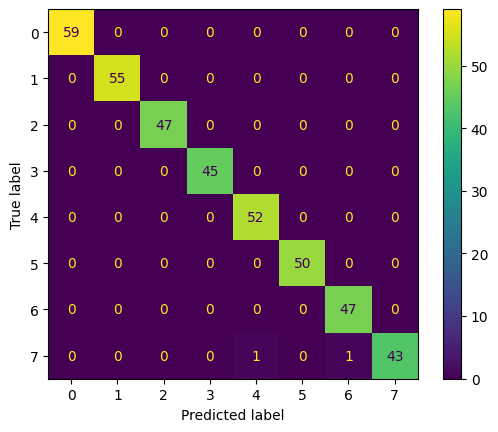

In [ ]:
!pip install torch
!pip install scikit-learn
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
test_predictions, test_labels = get_predictions_labels(model, dataloader_test_dataset, device)
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

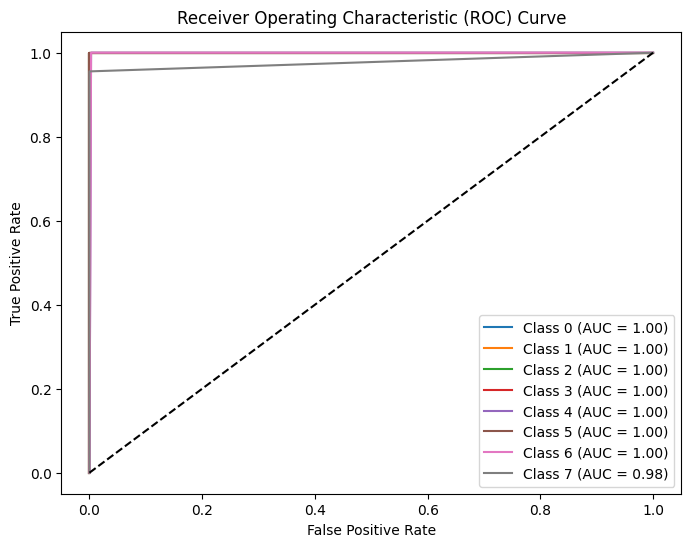

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


test_predictions, test_labels = get_predictions_labels(model, dataloader_test_dataset, device)

n_classes = total_class

y_test = label_binarize(test_labels, classes=list(range(n_classes)))
y_score = label_binarize(test_predictions, classes=list(range(n_classes)))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


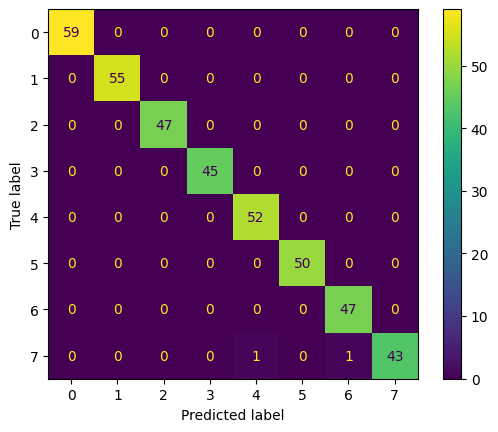

In [38]:
# prompt: confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have already defined 'get_predictions_labels', 'model',
# 'dataloader_test_dataset', and 'device'

test_predictions, test_labels = get_predictions_labels(model, dataloader_test_dataset, device)

# Calculate confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [39]:
# prompt: precision recall f1 specity

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(test_labels, test_predictions)

for i in range(total_class):
  print(f"Class {i}: Precision={precision[i]:.2f}, Recall={recall[i]:.2f}, F1={f1[i]:.2f}, Support={support[i]}")


Class 0: Precision=1.00, Recall=1.00, F1=1.00, Support=59
Class 1: Precision=1.00, Recall=1.00, F1=1.00, Support=55
Class 2: Precision=1.00, Recall=1.00, F1=1.00, Support=47
Class 3: Precision=1.00, Recall=1.00, F1=1.00, Support=45
Class 4: Precision=0.98, Recall=1.00, F1=0.99, Support=52
Class 5: Precision=1.00, Recall=1.00, F1=1.00, Support=50
Class 6: Precision=0.98, Recall=1.00, F1=0.99, Support=47
Class 7: Precision=1.00, Recall=0.96, F1=0.98, Support=45


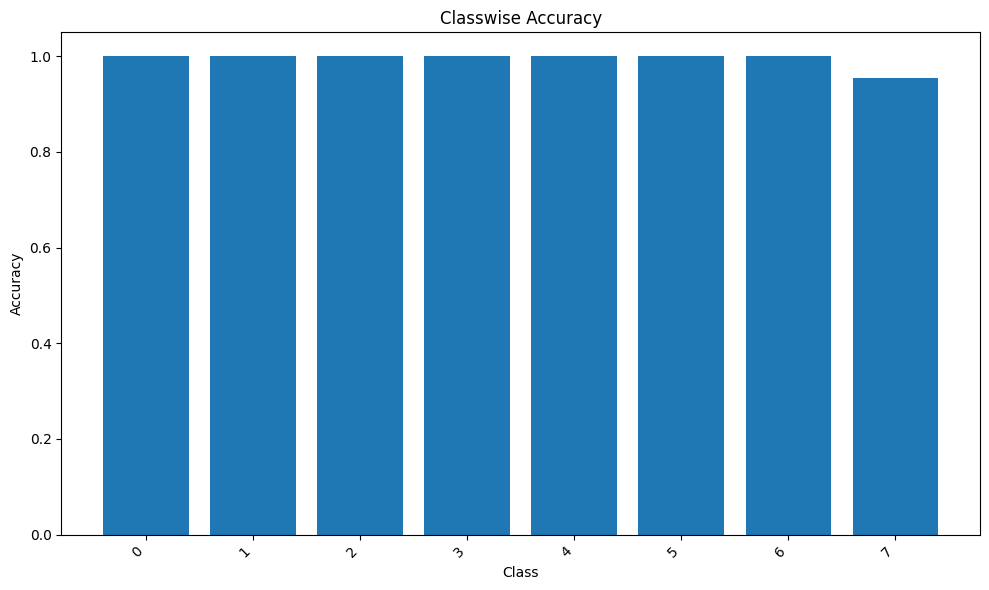

In [40]:
# prompt: classwise barchart accuracy

import matplotlib.pyplot as plt

def classwise_barchart_accuracy(class_acc, class_names):
  """
  Plots a classwise bar chart of accuracy.

  Args:
    class_acc: A list of class-wise accuracies.
    class_names: A list of class names.
  """
  plt.figure(figsize=(10, 6))
  plt.bar(class_names, class_acc)
  plt.xlabel("Class")
  plt.ylabel("Accuracy")
  plt.title("Classwise Accuracy")
  plt.xticks(rotation=45, ha="right")
  plt.tight_layout()
  plt.show()

# Assuming class_acc and class_names are defined elsewhere
classwise_barchart_accuracy(class_acc, class_names)


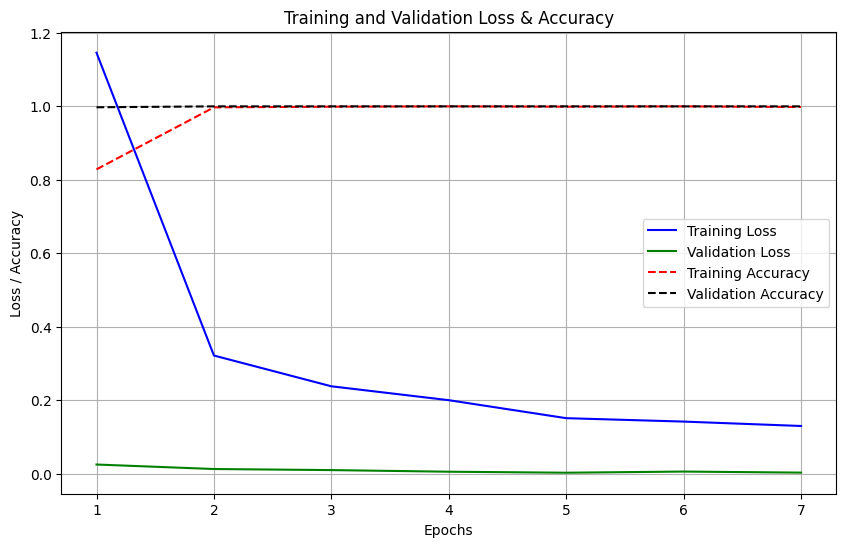

In [41]:
# prompt: loss curve accuracy curve in single graph together

plt.figure(figsize=(10, 6))

# Plotting loss
plt.plot(epochs, losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='green')

# Plotting accuracy
plt.plot(epochs, accuracies, label='Training Accuracy', color='red', linestyle='--')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='black', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Training and Validation Loss & Accuracy')
plt.legend()
plt.grid(True)
plt.show()
